In [13]:
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
tfk=tf.keras
tfkl=tf.keras.layers
tfd=tfp.distributions
tfb=tfp.bijectors
tfl=tfp.layers
import matplotlib.pyplot as plt
import precession
import random
random.seed(5)
tf.random.set_seed(5)
import math
import scipy

import re
%matplotlib inline
import corner
import h5py

In [2]:
def make_bijector_kwargs(bijector, name_to_kwargs):
  if hasattr(bijector, 'bijectors'):
      return {b.name: make_bijector_kwargs(b, name_to_kwargs) for b in bijector.bijectors}
  else:
      for name_regex, kwargs in name_to_kwargs.items():
          if re.match(name_regex, bijector.name):
              return kwargs
  return {}


In [14]:
def nf_model(ndim):
    bijects=[]

    bs=[tfb.Chain([tfb.Scale(scale=.5), tfb.Shift(1.), tfb.Tanh()]),tfb.Chain([tfb.Scale(scale=np.pi/2),tfb.Shift(1.), tfb.Tanh()]), tfb.Chain([tfb.Scale(scale=np.pi), tfb.Shift(1.) , tfb.Tanh()])]
    blockwise=tfb.Blockwise(bs, block_sizes=[3,2,1])
    bijects.append(blockwise)
    
    l2=tf.keras.regularizers.l2(l2=0.01)
    
    # Density estimation with MADE.
    for i in range(10):
      made = tfb.AutoregressiveNetwork(
        params=2,
        hidden_units=[1024],
        event_shape=(ndim,),
        conditional=True,
        conditional_event_shape=(1,),
        #conditional_input_layers='first_layer',
        activation='leaky_relu',
        kernel_initializer='RandomNormal',
        bias_initializer='RandomNormal',
        kernel_regularizer=l2
        # bias_regularizer='L2'
      )
      masked_made=tfb.MaskedAutoregressiveFlow(made, name=f'maf{i}')
      bijects.append(masked_made)
      print(masked_made)

      permute=tfb.Permute(list(reversed(range(ndim))))
      bijects.append(permute)

    final_bijector=tfb.Chain(bijects)


    distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(0., 1.), sample_shape=[ndim]),
    bijector=final_bijector)
    
    # Construct and fit model.
    x_ = tfkl.Input(shape=(ndim,), dtype=tf.float32)
    c_ = tfkl.Input(shape=(1,), dtype=tf.float32)


    log_prob_ = distribution.log_prob(x_,
    bijector_kwargs=make_bijector_kwargs(distribution.bijector, {'maf.': {'conditional_input': c_}}))

    model = tfk.Model([x_, c_], log_prob_)
    
    return [model, final_bijector]

    
    
    

In [15]:
model, final_bijector=nf_model(ndim=6)


tfp.bijectors.MaskedAutoregressiveFlow("maf0", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf1", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf2", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf3", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf4", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf5", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf6", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf7", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf8", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf9", batch_shape=[], min_event_ndims=1)


In [16]:
ndim=6
model.load_weights('maf5.hdf5')
distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(0., 1.), sample_shape=[ndim]),
    bijector=final_bijector)

(7886,)


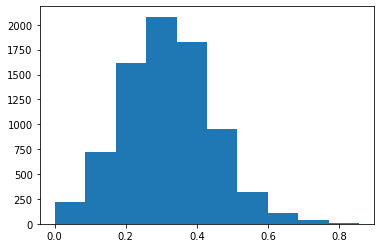

In [6]:
f = h5py.File('/data/mmould/lvc/GWTC-2.1_new/IGWN-GWTC2p1-v2-GW190412_053044_PEDataRelease_mixed_cosmo.h5', 'r')
f.keys()
f['C01:Mixed'].keys()
sorted(f['C01:Mixed']['posterior_samples'].dtype.names)
plt.hist(f['C01:Mixed']['posterior_samples']['a_1'])
print(f['C01:Mixed']['posterior_samples']['a_1'].shape)

In [33]:
sampled_dist=np.random.choice(f['C01:Mixed']['posterior_samples']['a_1'],int(1e3), replace=True)
sampled_dist.mean()

0.31801448543704486

In [34]:
col_samples=np.zeros((1,6))
for i in range(0,int(sampled_dist.shape[0])):
    samples = distribution.sample(
    int(1e3),
    bijector_kwargs=make_bijector_kwargs(
        distribution.bijector,
        {'maf.': {'conditional_input': np.array([sampled_dist[i]])}}),
        ).numpy()
    n_nan=np.isnan(samples).sum()//6
    
    samples_1, samples_r=np.zeros((samples.shape[0]-n_nan,1),dtype=np.float32), np.zeros((samples.shape[0]-n_nan,1),dtype=np.float32)
    for i in range(samples.shape[1]):
        samples_1=samples[np.isfinite(samples[:,i])][:,i].reshape(-1,1)
        samples_r=np.hstack([samples_r, samples_1])
        
    samples_r=samples_r[:,1:]
    
    col_samples=np.vstack((col_samples, samples_r))
    
    
col_samples=col_samples[1:,:]
col_samples
    
    
    
    
    

array([[0.15652749, 0.65592551, 0.09732595, 2.60796452, 0.8852393 ,
        5.28494263],
       [0.14235622, 0.45070463, 0.88607764, 2.41354656, 0.2372959 ,
        3.6120193 ],
       [0.06771973, 0.31959936, 0.91990107, 2.11510301, 2.18102241,
        5.93828154],
       ...,
       [0.0425255 , 0.06733379, 0.37996203, 0.60253793, 0.82433325,
        5.58499861],
       [0.06058681, 0.02549013, 0.0879834 , 1.38185322, 2.76958227,
        4.54009342],
       [0.06369716, 0.01241785, 0.62138301, 1.95551002, 0.80896217,
        3.60243368]])

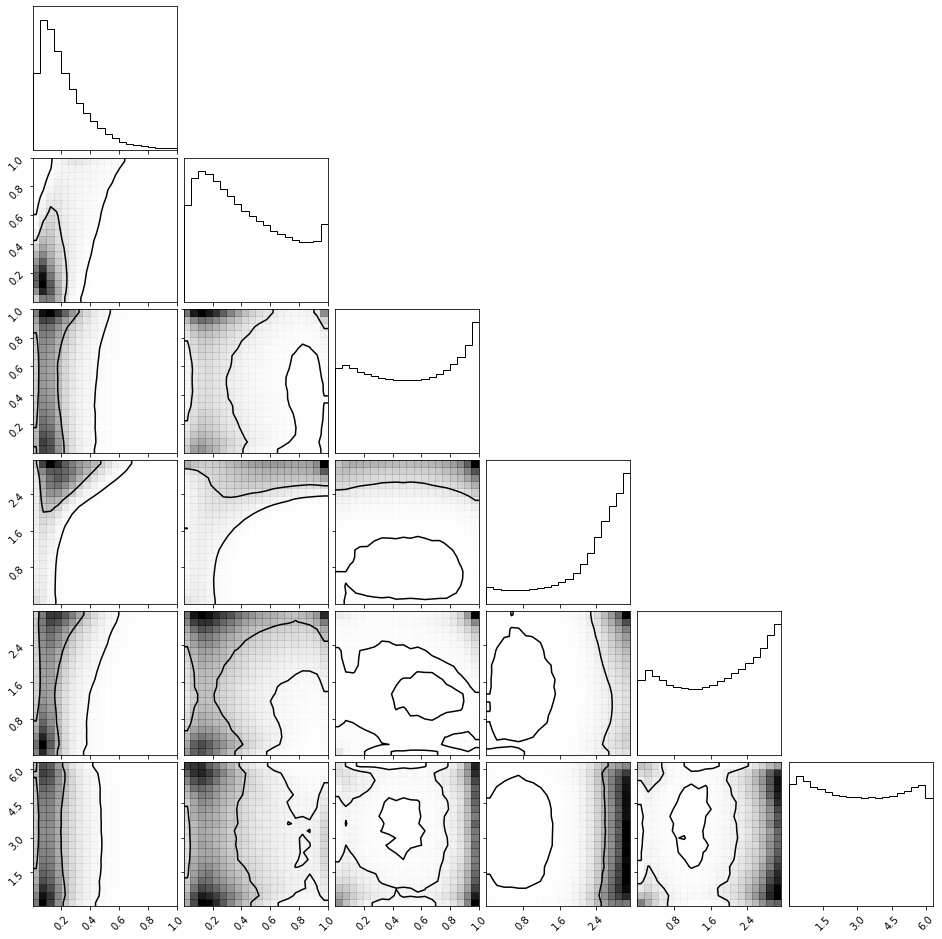

In [35]:
corner.corner(
    col_samples, plot_datapoints=False, plot_density=True,
    levels=[.5, .9], smooth=.5, label=['q,chi1,chi2,theta1,theta2,deltaphi']
    );


(7886,)


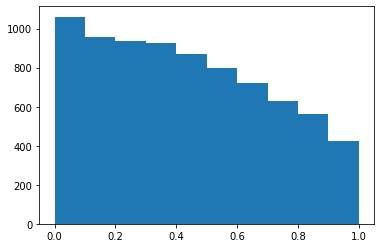

In [9]:
f = h5py.File('/data/mmould/lvc/GWTC-2.1_new/IGWN-GWTC2p1-v2-GW190412_053044_PEDataRelease_mixed_cosmo.h5', 'r')
f.keys()
f['C01:Mixed'].keys()
sorted(f['C01:Mixed']['posterior_samples'].dtype.names)
plt.hist(f['C01:Mixed']['posterior_samples']['a_2'])
print(f['C01:Mixed']['posterior_samples']['a_2'].shape)
sampled_dist=np.random.choice(f['C01:Mixed']['posterior_samples']['a_2'],int(1e4))

In [29]:
sampled_dist=np.random.choice(f['C01:Mixed']['posterior_samples']['a_2'],int(1e3))
sampled_dist.mean()

0.43535086636920417

In [30]:
col_samples_1=np.zeros((1,6))
for i in range(0,int(sampled_dist.shape[0])):
    samples = distribution.sample(
    int(1e3),
    bijector_kwargs=make_bijector_kwargs(
        distribution.bijector,
        {'maf.': {'conditional_input': np.array([sampled_dist[i]])}}),
        ).numpy()
    n_nan=np.isnan(samples).sum()//6
    
    samples_1, samples_r=np.zeros((samples.shape[0]-n_nan,1),dtype=np.float32), np.zeros((samples.shape[0]-n_nan,1),dtype=np.float32)
    for i in range(0,samples.shape[1]):
        samples_1=samples[np.isfinite(samples[:,i])][:,i].reshape(-1,1)
        samples_r=np.hstack([samples_r, samples_1])
        
    samples_r=samples_r[:,1:]
    
    col_samples_1=np.vstack((col_samples_1, samples_r))
    
    
col_samples_1=col_samples_1[1:,:]
col_samples_1
    
    
    
    
    

array([[0.0356386 , 0.12860176, 0.24670011, 1.83500981, 2.31330538,
        4.06349897],
       [0.19074059, 0.85496974, 0.76975119, 3.03950429, 1.86135507,
        2.09744954],
       [0.1661368 , 0.76828384, 0.54976463, 3.12339401, 0.75686252,
        5.65778351],
       ...,
       [0.67481703, 0.74460292, 0.48638391, 2.12100983, 0.13986424,
        3.59699059],
       [0.23813209, 0.59870815, 0.70863128, 1.42028129, 0.5985142 ,
        6.11220598],
       [0.96437311, 0.5401926 , 0.17740399, 1.97813106, 2.37490749,
        0.55139512]])

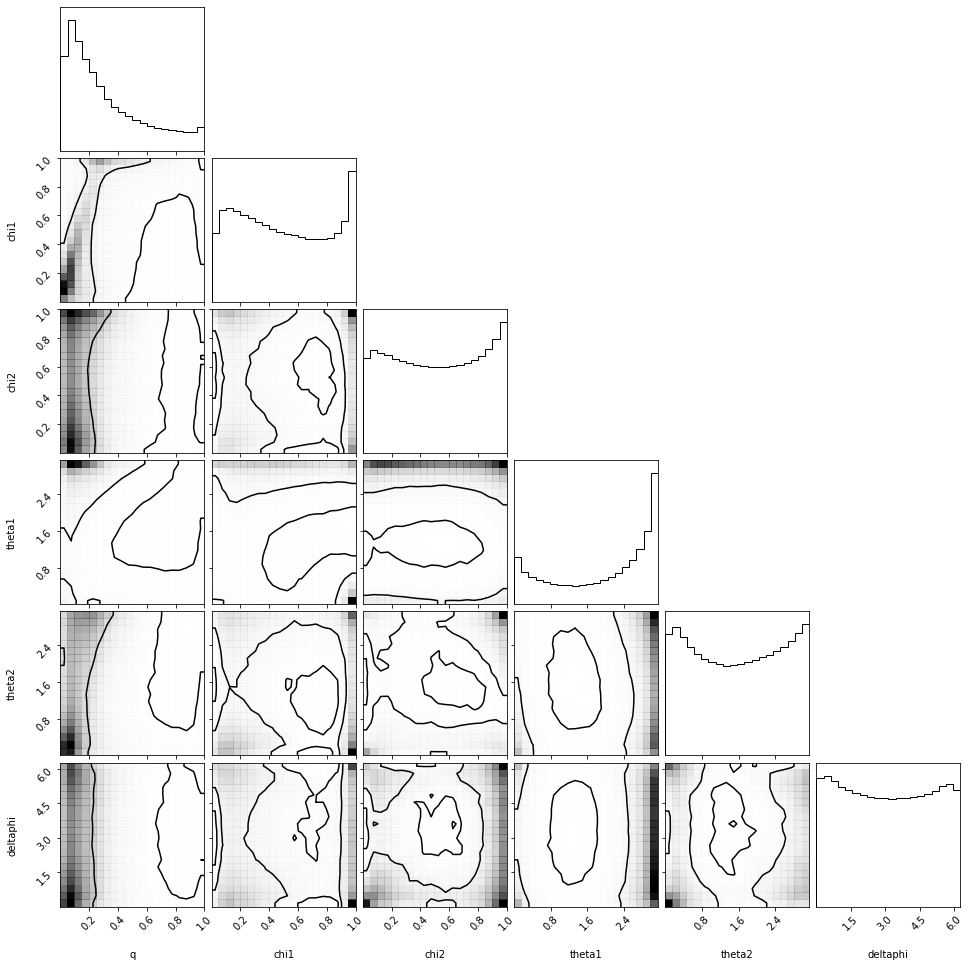

In [36]:
corner.corner(
    col_samples_1, plot_datapoints=False, plot_density=True,
    levels=[.5, .9], smooth=.5, labels=['q','chi1','chi2','theta1', 'theta2', 'deltaphi']
    );


In [27]:
sampled_dist=np.random.choice(f['C01:Mixed']['posterior_samples']['a_1'],int(1e4), replace=True)

In [28]:
import statistics
statistics.median(sampled_dist)

0.3173251525032933

In [8]:
sampled_dist=np.random.choice(f['C01:Mixed']['posterior_samples']['a_2'],int(1e4), replace=True)

NameError: name 'f' is not defined

In [ ]:
import statistics
statistics.median(sampled_dist)

In [37]:
samples = distribution.sample(
    int(1e5),
    bijector_kwargs=make_bijector_kwargs(
        distribution.bijector,
        {'maf.': {'conditional_input': np.array([0.62])}}),
        ).numpy()

n_nan=np.isnan(samples).sum()//6
    
samples_1, samples_r=np.zeros((samples.shape[0]-n_nan,1),dtype=np.float32), np.zeros((samples.shape[0]-n_nan,1),dtype=np.float32)
for i in range(samples.shape[1]):
    samples_1=samples[np.isfinite(samples[:,i])][:,i].reshape(-1,1)
    samples_r=np.hstack([samples_r, samples_1])

samples_r=samples_r[:,1:]


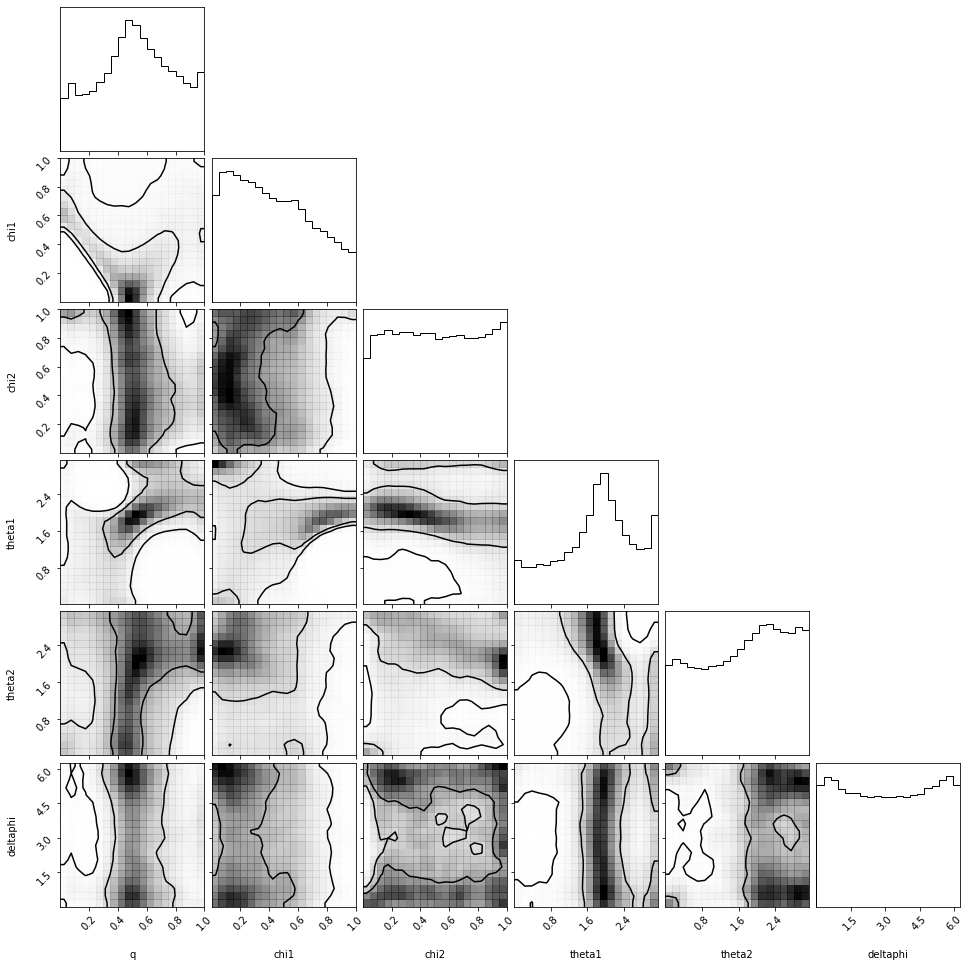

In [38]:
corner.corner(
    samples_r, plot_datapoints=False, plot_density=True,
    levels=[.5, .9], smooth=.8, labels=['q','chi1','chi2','theta1', 'theta2', 'deltaphi']
    );




In [50]:
col_samples

col_samples_1

array([[0.14932066, 0.41295302, 0.173127  , 2.86002493, 0.90359038,
        3.13266778],
       [0.05858332, 0.30960059, 0.06410015, 2.89522481, 3.03098774,
        1.00953388],
       [0.07122773, 0.11123466, 0.6070202 , 2.80160642, 2.67542243,
        3.47587991],
       ...,
       [0.40621156, 0.48429164, 0.35646492, 2.90146637, 1.75062585,
        3.01631331],
       [0.19984958, 0.04239807, 0.86947685, 1.6987952 , 3.00743675,
        5.95407248],
       [0.45096278, 0.89712346, 0.75736737, 2.44667816, 2.5078485 ,
        3.67147422]])

(7886,)


0.405735940535967

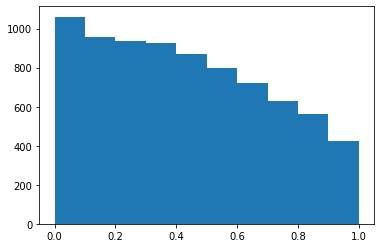

In [68]:
plt.hist(f['C01:Mixed']['posterior_samples']['a_2'])
print(f['C01:Mixed']['posterior_samples']['a_2'].shape)
statistics.median(f['C01:Mixed']['posterior_samples']['a_2'])

(7886,)


0.3147221567094267

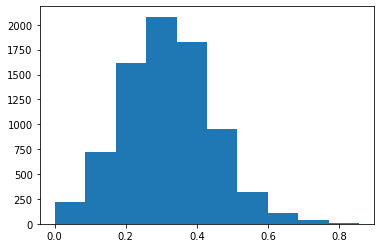

In [70]:
plt.hist(f['C01:Mixed']['posterior_samples']['a_1'])
print(f['C01:Mixed']['posterior_samples']['a_1'].shape)
statistics.median(f['C01:Mixed']['posterior_samples']['a_1'])

(array([1383., 1179., 1186., 1132., 1139., 1013.,  915.,  821.,  697.,
         535.]),
 array([1.10284436e-04, 9.99790726e-02, 1.99847861e-01, 2.99716649e-01,
        3.99585437e-01, 4.99454225e-01, 5.99323013e-01, 6.99191801e-01,
        7.99060589e-01, 8.98929378e-01, 9.98798166e-01]),
 <BarContainer object of 10 artists>)

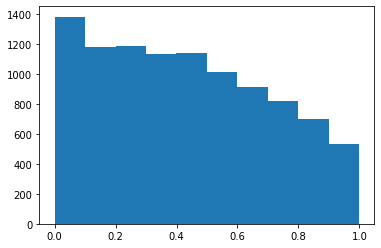

In [74]:
plt.hist(sampled_dist)

In [224]:
import json

In [271]:
with open("catalog (1).json") as file:
    f = json.load(file)
len(f)

2028

In [272]:
list=[]
for i in range(len(f)):
    try:
        np.float32(f[i]['reference_mass_ratio'])
        np.linalg.norm(f[i]['reference_dimensionless_spin1'])
        np.linalg.norm(f[i]['reference_dimensionless_spin2']) 
        np.linalg.norm(f[i]['remnant_dimensionless_spin'])
    except:
        list.append(i)
f=np.delete(f,list, axis=0)

In [273]:
len(f)

2026

In [274]:
q=np.array([np.float32(d['reference_mass_ratio']) for d in f]).reshape(-1,1)
chi1=np.array([np.linalg.norm(d['reference_dimensionless_spin1']) for d in f]).reshape(-1,1)
chi2=np.array([np.linalg.norm(d['reference_dimensionless_spin2']) for d in f]).reshape(-1,1)
chif=np.array([np.linalg.norm(d['remnant_dimensionless_spin']) for d in f]).reshape(-1,1)

In [291]:
x=np.hstack([q,chi1,chi2])
c=chif

print(x.shape)
print(c.shape)

(2026, 3)
(2026, 1)


In [289]:
list=[]
for i in range(0,x.shape[0]):
    if np.isnan(x[i]).sum()!=0 or np.isnan(c[i]).sum()!=0:
        list.append(i)

x=np.delete(x,i,0)
c=np.delete(c,i,0)

print(x.shape)
print(c.shape)


(2025, 3)
(2025, 1)
